In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [15]:
# DATA_DIR = "data"
# data_df = pd.read_csv(os.path.join(DATA_DIR, 'merged_data.csv'))

data_df = pd.read_csv('..\data\merged_data.csv')

In [16]:
# rename columns for Prophet compatibility
data_df = data_df.rename(columns={"Year": "ds", "Life expectancy": "y"})

# convert 'ds' to datetime format
data_df["ds"] = pd.to_datetime(data_df["ds"], format="%Y")

# split data into training (2000-2016) and testing (2017-2021)
train_df = data_df[(data_df["ds"].dt.year >= 2000) & (data_df["ds"].dt.year <= 2016)]
test_df = data_df[(data_df["ds"].dt.year >= 2017) & (data_df["ds"].dt.year <= 2021)]

In [ ]:
# function to train Prophet model with one external regressor
def train_and_forecast(train_data, test_data, regressor):
    model = Prophet()
    model.add_regressor(regressor)
    model.fit(train_data)

    # create future dataframe
    future = test_data[["ds", regressor]]
    # future = model.make_future_dataframe(periods=len(test_df), freq="YE")

    # predict
    forecast = model.predict(future)

    # merge with actual values
    results = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    results = results.merge(test_data[["ds", "y"]], on="ds", how="left")
    results["Error"] = abs(results["yhat"] - results["y"])  # calculate absolute error

    return results

In [21]:
# train three models with different regressors
regressors = ["Daily calorie supply", "GDP per capita", "Health expenditure as percentage of GDP"]
predictions = {}

for reg in regressors:
    predictions[reg] = train_and_forecast(train_df[["ds", "y", reg]], test_df[["ds", "y", reg]], reg)

21:41:40 - cmdstanpy - INFO - Chain [1] start processing
21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing
21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing
21:41:54 - cmdstanpy - INFO - Chain [1] done processing


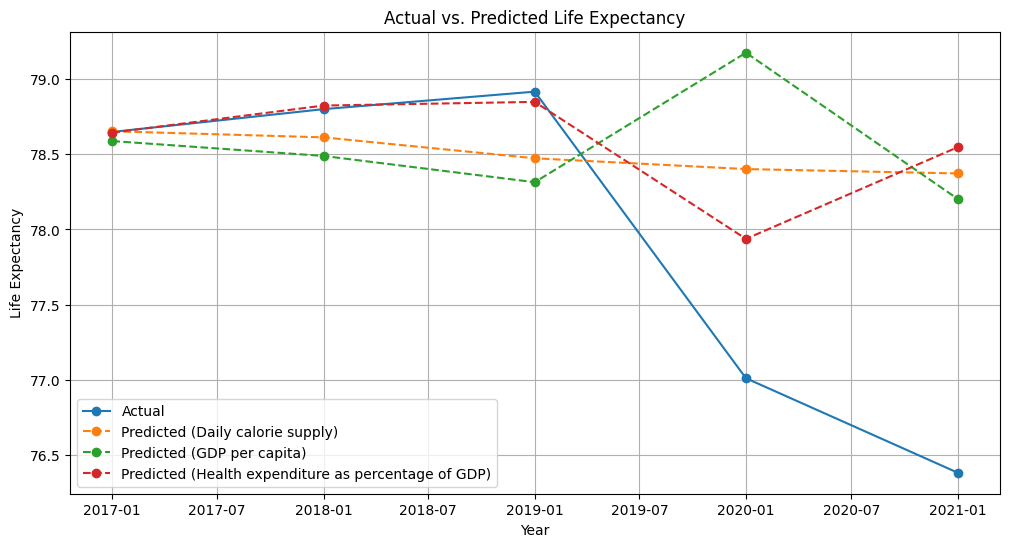

In [22]:
# plot results
plt.figure(figsize=(12, 6))
plt.plot(test_df["ds"], test_df["y"], label="Actual", marker="o", linestyle="-")

for reg, pred in predictions.items():
    plt.plot(pred["ds"], pred["yhat"], marker="o", linestyle="--", label=f"Predicted ({reg})")

plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.title("Actual vs. Predicted Life Expectancy")
plt.legend()
plt.grid()
plt.show()

In [24]:
# display tables
for reg, pred in predictions.items():
    print(f"\nResults for model with {reg} as regressor:\n")
    print(pred.to_string(index=False))


Results for model with Daily calorie supply as regressor:

        ds      yhat  yhat_lower  yhat_upper       y    Error
2017-01-01 78.652863   78.533053   78.756450 78.6483 0.004563
2018-01-01 78.612199   78.224200   78.944784 78.7997 0.187501
2019-01-01 78.473264   77.775220   79.107881 78.9160 0.442736
2020-01-01 78.401488   77.282653   79.463638 77.0115 1.389988
2021-01-01 78.372395   76.731180   79.914612 76.3836 1.988795

Results for model with GDP per capita as regressor:

        ds      yhat  yhat_lower  yhat_upper       y    Error
2017-01-01 78.587651   78.379295   78.788457 78.6483 0.060649
2018-01-01 78.488711   77.795744   79.124466 78.7997 0.310989
2019-01-01 78.314141   76.985707   79.559435 78.9160 0.601859
2020-01-01 79.174662   77.035871   81.197336 77.0115 2.163162
2021-01-01 78.203095   75.097604   81.184638 76.3836 1.819495

Results for model with Health expenditure as percentage of GDP as regressor:

        ds      yhat  yhat_lower  yhat_upper       y    Error
2

In [25]:
# calculate MAE for each model
for reg, pred in predictions.items():
    mae = mean_absolute_error(test_df["y"], pred["yhat"])
    print(f"MAE for model with {reg}: {mae:.2f}")

MAE for model with Daily calorie supply: 0.80
MAE for model with GDP per capita: 0.99
MAE for model with Health expenditure as percentage of GDP: 0.64


In [ ]:
'''
For future (beyong 2021) forecasting: to prevent large dips from being captured by the trend component, we treat the years 
(2020, 2021) impacted by COVID-19 as holidays that will not repeat again in the future.
'''
covid_holidays = pd.DataFrame({
    "holiday": "COVID-19",
    "ds": pd.to_datetime(["2020-01-01", "2021-01-01"]),
    "lower_window": 0,
    "upper_window": 0
})